# TF-IDF dataset creation for COVID19

This kernel takes my [pre-processed COVID19 NLP dataset](https://www.kaggle.com/donkeys/covid-nlp-preprocess) and calculates TF-IDF scores for the documents in that set. It also creates an inverted index for the same data. See the [dataset example notebook](https://www.kaggle.com/donkeys/starter-covid-tf-idf-and-inverse-index-2707b22c-a) for more details on what it produces.

The resulting models are saved as a [new dataset](https://www.kaggle.com/donkeys/covid-tfidf) for future kernels.

In [1]:
import os
import numpy as np
import pandas as pd 
from memory_profiler import profile
from typing import List

import kaggle_uploader

In [2]:
!pip install memory_utils

In [3]:
import memory_utils

memory_utils.print_memory()

RSS                  Delta                Message
107,958,272          107,958,272         


In [4]:
from tqdm.auto import tqdm
tqdm.pandas()

In [5]:
!ls -l /kaggle/input/covid-nlp-preprocess

total 4
drwxr-xr-x 4 nobody nogroup 4096 Apr 25 13:52 output


In [6]:
!ls -l /kaggle/

total 20
drwxr-xr-x 4 root root 4096 Apr 28 19:51 input
drwxr-xr-x 3 root root 4096 Apr 28 19:51 lib
drwxr-xr-x 2 root root 4096 Apr 28 19:51 src
drwxr-xr-x 3 root root 4096 Apr 28 19:51 usr
drwxr-xr-x 2 root root 4096 Apr 28 19:51 working


In [7]:
!du .

24	.


In [8]:
class COVDoc:
    def __init__(self):
        self.doc_id = None
        self.filepath_proc = None
        self.filepath_orig = None
        self.text_proc = None
        self.text_orig = None
        self.tokenized_proc = None
        self.doc_type = None
    
    #this function allows me to lazy-load the original text to save memory
    def load_orig(self):
            with open(self.filepath_orig) as f:
                d = json.load(f)
                body = ""
                for idx, paragraph in enumerate(d["body_text"]):
                    body += f" {paragraph}"
                self.text_orig = body

In [9]:
class DocList:
    doc_list: List[COVDoc] = None
    doc_mode = True
    full_text_mode = False
    #this index will break if multiple iterations at the same time. then need separate object
    iter_idx = 0
    
    def __init__(self):
        self.doc_list = []
        
    def append(self, item:COVDoc):
        self.doc_list.append(item)
    
    def __iter__(self):
        iter_idx = 0
        def doc_iterator(docs):
            for doc in docs:
                #doc_mode = mode where the whole document object is returned
                if self.doc_mode:
                    yield doc
                    continue
                #full_text_mode = mode where the full text is returned in one long string
                if self.full_text_mode:
                    tmp = " ".join(doc.text_proc)
                    yield tmp
                    del tmp
                    continue
                #default mode if not doc_mode or full_text_mode, return whole document as list of words
                yield doc.text_proc
            return 
        return doc_iterator(self.doc_list)
    
    def __len__(self):
        return len(self.doc_list)
    

    

In [10]:
import glob, os, json

paragraphs = []

def load_docs(base_path, base_path_orig, doc_type):
    loaded_docs = DocList()
    file_paths_proc = glob.glob(base_path)
    file_names_proc = [os.path.basename(path) for path in file_paths_proc]
    file_names_orig = [os.path.splitext(filename)[0]+".json" for filename in file_names_proc]
    file_paths_orig = []
    for filename in file_names_orig:
        if filename.startswith("PMC"):
            file_paths_orig.append(os.path.join(base_path_orig, "pmc_json", filename))
        else:
            file_paths_orig.append(os.path.join(base_path_orig, "pdf_json", filename))
#        file_paths_orig = [os.path.join(base_path_orig, filename) for filename in file_names_orig]
    for idx, filepath_proc in enumerate(tqdm(file_paths_proc)):
        doc = COVDoc()
        doc.doc_type = doc_type
        loaded_docs.append(doc)
        doc.filepath_proc = filepath_proc
        doc.filepath_orig = file_paths_orig[idx]
        with open(filepath_proc) as f:
            d = f.read()
            #print(d)
            tokenized = d.strip().split(" ")
            tokenized[0] = tokenized[0].strip()
            doc.doc_id = tokenized[0]
            del tokenized[0]
            doc.text_proc = tokenized
    return loaded_docs

In [11]:
memory_utils.print_memory()

108,326,912          368,640             


In [12]:
!ls -l /kaggle/input/covid-nlp-preprocess/output/whole

total 2300
drwxr-xr-x 2 nobody nogroup  126976 Apr 25 13:53 biorxiv_medrxiv
drwxr-xr-x 2 nobody nogroup  507904 Apr 25 13:53 comm_use_subset
drwxr-xr-x 2 nobody nogroup 1585152 Apr 25 13:54 custom_license
drwxr-xr-x 2 nobody nogroup  131072 Apr 25 13:54 noncomm_use_subset


In [13]:
df_metadata = pd.read_csv("/kaggle/input/CORD-19-research-challenge/metadata.csv")
df_metadata.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,zjufx4fo,b2897e1277f56641193a6db73825f707eed3e4c9,PMC,Sequence requirements for RNA strand transfer ...,10.1093/emboj/20.24.7220,PMC125340,11742998.0,unk,Nidovirus subgenomic mRNAs contain a leader se...,2001-12-17,"Pasternak, Alexander O.; van den Born, Erwin; ...",The EMBO Journal,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc125340?pdf=re...
1,ymceytj3,e3d0d482ebd9a8ba81c254cc433f314142e72174,PMC,"Crystal structure of murine sCEACAM1a[1,4]: a ...",10.1093/emboj/21.9.2076,PMC125375,11980704.0,unk,CEACAM1 is a member of the carcinoembryonic an...,2002-05-01,"Tan, Kemin; Zelus, Bruce D.; Meijers, Rob; Liu...",The EMBO Journal,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc125375?pdf=re...
2,wzj2glte,00b1d99e70f779eb4ede50059db469c65e8c1469,PMC,Synthesis of a novel hepatitis C virus protein...,10.1093/emboj/20.14.3840,PMC125543,11447125.0,no-cc,Hepatitis C virus (HCV) is an important human ...,2001-07-16,"Xu, Zhenming; Choi, Jinah; Yen, T.S.Benedict; ...",EMBO J,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
3,2sfqsfm1,cf584e00f637cbd8f1bb35f3f09f5ed07b71aeb0,PMC,Structure of coronavirus main proteinase revea...,10.1093/emboj/cdf327,PMC126080,12093723.0,unk,The key enzyme in coronavirus polyprotein proc...,2002-07-01,"Anand, Kanchan; Palm, Gottfried J.; Mesters, J...",The EMBO Journal,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc126080?pdf=re...
4,i0zym7iq,dde02f11923815e6a16a31dd6298c46b109c5dfa,PMC,Discontinuous and non-discontinuous subgenomic...,10.1093/emboj/cdf635,PMC136939,12456663.0,unk,"Arteri-, corona-, toro- and roniviruses are ev...",2002-12-01,"van Vliet, A.L.W.; Smits, S.L.; Rottier, P.J.M...",The EMBO Journal,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc136939?pdf=re...


In [14]:
med_docs = load_docs("/kaggle/input/covid-nlp-preprocess/output/whole/biorxiv_medrxiv/*.txt", "/kaggle/input/CORD-19-research-challenge/biorxiv_medrxiv/biorxiv_medrxiv", "medx")
len(med_docs)

2087

In [15]:
memory_utils.print_memory()

646,959,104          538,632,192         


In [16]:
comuse_docs = load_docs("/kaggle/input/covid-nlp-preprocess/output/whole/comm_use_subset/*.txt", "/kaggle/input/CORD-19-research-challenge/comm_use_subset/comm_use_subset", "comm_user")
len(comuse_docs)

8682

In [17]:
memory_utils.print_memory()

2,025,984,000        1,379,024,896       


In [18]:
noncom_docs = load_docs("/kaggle/input/covid-nlp-preprocess/output/whole/noncomm_use_subset/*.txt", "/kaggle/input/CORD-19-research-challenge/noncomm_use_subset/noncomm_use_subset", "noncomm")
len(noncom_docs)

2102

In [19]:
memory_utils.print_memory()

2,348,134,400        322,150,400         


In [20]:
custom_docs = load_docs("/kaggle/input/covid-nlp-preprocess/output/whole/custom_license/*.txt", "/kaggle/input/CORD-19-research-challenge/custom_license/custom_license", "custom")
len(custom_docs)

27073

In [21]:
memory_utils.print_memory()

6,749,396,992        4,401,262,592       


In [22]:
all_doc_lists = [med_docs, comuse_docs, noncom_docs, custom_docs]

In [23]:
memory_utils.print_memory()

In [24]:
total_docs = 0
for doc_list in all_doc_lists:
    total_docs += len(doc_list)
total_docs

39944

In [25]:
import collections

def count_words():
    word_count = collections.Counter()
    with tqdm(total=total_docs) as pbar:
        for doc_list in all_doc_lists:
            doc_list.doc_mode = False
            for doc_text in doc_list:
                word_count.update(doc_text)
                pbar.update()
    return word_count

word_count = count_words()
len(word_count)

248062

In [26]:
memory_utils.print_memory()

6,769,623,040        20,226,048          


In [27]:
def redo_docs():
    #all_texts = []
    with tqdm(total=total_docs) as pbar:
        for doc_list in all_doc_lists:
            doc_list.doc_mode = True
            for doc in doc_list:
                text = []
                for token in doc.text_proc:
                    if word_count[token] < 20:
                        splits = token.split("_")
                        if len(splits) > 1:
                            text.extend(splits)
                    else:
                        text.append(token)
                #text = [token for token in doc.text_proc if word_count[token] > 20]
                doc.text_proc = text
                pbar.update()
            #all_texts.extend(" ".join(doc.text_proc) for doc in doc_list)
    #return all_texts

#redo_docs()

In [28]:
memory_utils.print_memory()

In [29]:
#redo_docs()
word_count = count_words()
len(word_count)

248062

In [30]:
memory_utils.print_memory()

6,770,077,696        454,656             


In [31]:
all_docs = DocList()
all_docs.doc_mode = False
all_docs.full_text_mode = True
for doc_list in all_doc_lists:
    doc_list.doc_mode = True
    all_docs.doc_list.extend(doc_list)


In [32]:
all_docs.doc_list[0]

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

#https://stackoverflow.com/questions/34449127/sklearn-tfidf-transformer-how-to-get-tf-idf-values-of-given-words-in-documen?noredirect=1&lq=1
vect = TfidfVectorizer()
tfidf_matrix = vect.fit_transform(all_docs)
feature_names = vect.get_feature_names()
#TODO: tqdm in custom iterator

In [34]:
memory_utils.print_memory()

7,257,526,272        487,448,576         


In [35]:
def weights_for_doc(doc_idx):
    feature_index = tfidf_matrix[doc_idx , :].nonzero()[1]
    tfidf_scores = zip(feature_index, [tfidf_matrix[doc_idx, x] for x in feature_index])
    return tfidf_scores


In [36]:
word_count["bob"]

123

In [37]:
threshold_sizes = []
for x in tqdm(range(200)):
    n_of_words = 0
    for word, count in word_count.items():
        if count > x:
            n_of_words += 1
    threshold_sizes.append(n_of_words)
    

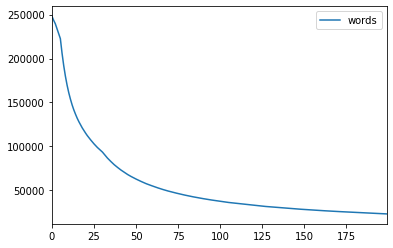

In [38]:
threshold_df = pd.DataFrame()
threshold_df["words"] = threshold_sizes
threshold_df.plot()

In [39]:
pd.set_option('display.max_rows', 500)
threshold_df.head(10)


,words
0,248062
1,243470
2,239520
3,233784
4,228295
5,222602
6,206015
7,191841
8,179848
9,169677


Based on above plots and table, I will pick a number to reduce the size of the inverted index. For the use case in mind, it seems fine for me to go with 100 or even higher for minumum word count. A threshold of 100 should reduce the index size to about 1/7th of full size. Otherwise this kernel keeps running out of memory and downstream kernels would have big issues as well..

In [40]:
index_threshold = 100

In [41]:
import collections

word_count = collections.Counter()
all_docs.full_text_mode = False
all_docs.doc_mode = False
for doc_text in tqdm(all_docs):
    word_count.update(doc_text)
len(word_count)


248062

In [42]:
all_docs.full_text_mode = False
all_docs.doc_mode = True
all_doc_ids = [doc.doc_id for doc in all_docs]
all_doc_ids[:10]

['byxd4o4m',
 'lqpk3ig7',
 'xk6tgja6',
 'uqxilq4l',
 'kh5qemo1',
 'cadwqsfd',
 '5dhmmcy6',
 '1zp6bn1h',
 'gzao2fo6',
 '32z7b3fp']

In [43]:
memory_utils.print_memory()

7,249,793,024        -7,733,248          


In [44]:
from collections import defaultdict

i_index = defaultdict(list)

skipped = 0
not_skipped = 0
for idx in tqdm(range(len(all_docs))):
    tfidf_scores = weights_for_doc(idx)
    #weighted_features = []
    for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
        wc = word_count[w]
        if wc < index_threshold:
            #reduce size of index or it will not fit in memory
            skipped += 1
            continue
        not_skipped += 1
        n_s = np.float32(s)
        n_idx = np.uint16(idx)
        i_index[w].append((n_idx, n_s))
#        weighted_features.append((w,s))
    del tfidf_scores
#print(tfidf_scores)
print(f"skipped {skipped} features, used {not_skipped} features")
#TODO: numpy arrays


skipped 2822761 features, used 29053553 features


In [45]:
memory_utils.print_memory()

10,773,786,624       3,523,993,600       


In [46]:
from operator import itemgetter

count = 0
for word_list in tqdm(i_index.values()):
    word_list.sort(key=itemgetter(1), reverse=True)
    count += 1


In [47]:
memory_utils.print_memory()

10,774,478,848       692,224             


In [48]:
for word in tqdm(i_index):
    np_scores = np.array(i_index[word])
    i_index[word] = np_scores

In [49]:
memory_utils.print_memory()

7,675,727,872        -3,098,750,976      


In [50]:
memory_utils.print_memory()

In [51]:
i_index["patient"][:20][0][0]

32309.0

In [52]:
!mkdir upload_dir

In [53]:
import pickle

with open("upload_dir/tfidf_matrix.pickle", "wb") as f:
    pickle.dump(tfidf_matrix, f)
    
memory_utils.print_memory()

!ls -l upload_dir

7,674,687,488        -1,040,384          
total 373708
-rw-r--r-- 1 root root 382675954 Apr 28 20:16 tfidf_matrix.pickle


In [54]:
with open("upload_dir/feature_names.pickle", "wb") as f:
    pickle.dump(feature_names, f)#

memory_utils.print_memory()

!ls -l upload_dir

7,699,050,496        24,363,008          
total 379432
-rw-r--r-- 1 root root   5858855 Apr 28 20:16 feature_names.pickle
-rw-r--r-- 1 root root 382675954 Apr 28 20:16 tfidf_matrix.pickle


In [55]:
with open("upload_dir/i_index.pickle", "wb") as f:
    pickle.dump(i_index, f)

memory_utils.print_memory()

!ls -l upload_dir

7,546,736,640        -152,313,856        
total 609268
-rw-r--r-- 1 root root   5858855 Apr 28 20:16 feature_names.pickle
-rw-r--r-- 1 root root 235351182 Apr 28 20:16 i_index.pickle
-rw-r--r-- 1 root root 382675954 Apr 28 20:16 tfidf_matrix.pickle


In [56]:
with open("upload_dir/doc_ids.pickle", "wb") as f:
    pickle.dump(all_doc_ids, f)

memory_utils.print_memory()

!ls -l upload_dir

7,550,242,816        3,506,176           
total 609972
-rw-r--r-- 1 root root    718313 Apr 28 20:16 doc_ids.pickle
-rw-r--r-- 1 root root   5858855 Apr 28 20:16 feature_names.pickle
-rw-r--r-- 1 root root 235351182 Apr 28 20:16 i_index.pickle
-rw-r--r-- 1 root root 382675954 Apr 28 20:16 tfidf_matrix.pickle


In [57]:
import kaggle_uploader

from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
api_secret = user_secrets.get_secret("kaggle api key")

kaggle_uploader.resources = []
kaggle_uploader.init_on_kaggle("donkeys", api_secret)
kaggle_uploader.base_path = "./upload_dir"
kaggle_uploader.title = "COVID TF-IDF"
kaggle_uploader.dataset_id = "covid-tfidf"
kaggle_uploader.user_id = "donkeys"
kaggle_uploader.add_resource("doc_ids.pickle", "pickled doc ids for TF-IDF outputs")
kaggle_uploader.add_resource("tfidf_matrix.pickle", "pickled TF-IDF matrix for covid19 dataset")
kaggle_uploader.add_resource("feature_names.pickle", "pickled TF-IDF features names")
kaggle_uploader.add_resource("i_index.pickle", "pickled inverted TF-IDF index for covid19 dataset")
kaggle_uploader.update("new version from kernel")
#kaggle_uploader.update("new version")



/kaggle/working/upload_dir
/kaggle/working/upload_dir
/kaggle/working/upload_dir
/kaggle/working/upload_dir
running cmd:['kaggle', 'datasets', 'version', '-p', '/kaggle/working/upload_dir', '-m', '"new version from kernel"']
Starting upload for file tfidf_matrix.pickle
Upload successful: tfidf_matrix.pickle (365MB)
Starting upload for file doc_ids.pickle
Upload successful: doc_ids.pickle (701KB)
Starting upload for file i_index.pickle
Upload successful: i_index.pickle (224MB)
Starting upload for file feature_names.pickle
Upload successful: feature_names.pickle (6MB)
Dataset version is being created. Please check progress at https://www.kaggle.com/donkeys/covid-tfidf



{'title': 'COVID TF-IDF',
 'id': 'donkeys/covid-tfidf',
 'licenses': [{'name': 'CC0-1.0'}],
 'resources': [{'path': '/kaggle/working/upload_dir/doc_ids.pickle',
   'description': 'pickled doc ids for TF-IDF outputs'},
  {'path': '/kaggle/working/upload_dir/tfidf_matrix.pickle',
   'description': 'pickled TF-IDF matrix for covid19 dataset'},
  {'path': '/kaggle/working/upload_dir/feature_names.pickle',
   'description': 'pickled TF-IDF features names'},
  {'path': '/kaggle/working/upload_dir/i_index.pickle',
   'description': 'pickled inverted TF-IDF index for covid19 dataset'}]}